### 1. How to simulate the future price of an asset using Geometric Brownian Motion ?

In [1]:
library(ggplot2)
library(quantmod)
library(reshape)
library(arrayhelpers)
options(repr.plot.width=7, repr.plot.height=3)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.
Package arrayhelpers, version 1.0-20160527

If you use this package please cite it appropriately.
   citation("arrayhelpers")
will give you the correct reference.

The project homepage is http://arrayhelpers.r-forge.r-project.org/




We start by a reminder of what Geometric Brownian Motion is. In mathematical terms: 

$ \frac{dS_t}{S_t} = \mu dt + \sigma  \sqrt{dt}  \epsilon $ 

Please remember that $\mu, \sigma$ are, respectively, the mean and standard deviation of **returns**. 

Using the Euler-Maruyama method, we can find a approximation of the differential equation above and define $dS_t$ as being  $S_{t+1} - S_t$, we get : 

$ S_{t+1} = S_t(1 + \mu dt + \sigma \sqrt{dt} \epsilon) $ 

The procedure of Monte-Carlo in order to simulate future price is to create different *price paths* and then compute their average. We will see how well the procedure works for predicting future price of an asset. 

We create a dataframe that will have for first column the dates of each prices of FB. In the second row we will find the price of FB and all other columns specified by the variable **nb_mc** will be simulations. 

In [2]:
nb_mc = 50
df_mc = data.frame(matrix(NA, nrow=500, ncol=nb_mc))

x = getSymbols('FB', env=NULL )

#take only the 500 last points of the data
df_mc[,1]= tail(index(x), 500)
df_mc[,2] = tail(x[, 6], 500)

#get the mean and std of returns
mu= mean(diff(log(df_mc[,2])), na.rm=T)
sigma = sd(diff(log(df_mc[,2])), na.rm=T)


'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.



Here the code get sligthly more messy. We need to go through each increment of the price (rows) and this each paths that we want to simulate (columns). The first loop moves us through the columns. We start from the third since the two first columns of our dataframe contains the dates and prices of FB. And up to **nb_mc** minus one because we will use the last column to compute the average of the simulations.

The second loop moves us through the rows. We start from the 250th step so we get the price paths starting the 250th date. 

This statement: df_mc\[249,j\] = df_mc\[249,2\] insure that the initial price point for all path is the same and equal to the real price path. 


The function **apply()** allow us to use a function and generalize it for a matrix. By specifying the MARGIN parameter ( if 1: ROWS, if 2: COLUMNS). We create for the last column the average path: the result from our Monte-Carlo procedure. 

In [3]:
for(j in 3:(ncol(df_mc)-1)){
  df_mc[249,j] = df_mc[249,2]
    
  for(i in 250:500){
    df_mc[i, j] = df_mc[i-1,j]*(1 + mu + sigma*rnorm(1,0,1))
  }
}

df_mc[,nb_mc] = apply(X=df_mc[,3:(nb_mc-1)], FUN='mean', MARGIN = 1)

tail(df_mc)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
495,2019-10-25,187.89,177.6525,170.7108,128.1607,134.2840,228.5487,112.6466,186.2644,124.3694,...,159.6200,190.1508,214.3832,104.3724,113.9338,227.7319,177.5987,69.44411,92.90524,167.5570
496,2019-10-28,189.40,176.8524,164.7845,131.5777,139.6070,220.8757,113.0379,185.4758,125.4992,...,157.6634,183.2790,219.3653,106.1204,112.3388,226.4118,174.1731,70.12870,94.01576,166.8329
497,2019-10-29,189.31,172.4688,163.3856,135.4702,146.1721,224.6823,116.6570,186.7532,125.7621,...,155.6495,182.4136,217.7748,105.9485,112.7986,231.3297,177.7565,70.39082,93.81573,167.2227
498,2019-10-30,188.25,173.0228,160.2815,131.7432,138.2753,227.6401,114.9463,192.4953,128.1428,...,156.6685,183.6111,214.7320,108.3364,110.6150,230.8918,174.2717,71.14651,95.49114,167.8214
499,2019-10-31,191.65,176.0321,156.8636,129.0077,139.1915,230.3398,113.7690,199.7940,131.0480,...,157.5871,189.0691,206.6561,109.4422,109.3192,232.2002,165.5017,73.48273,98.96350,168.5133
500,2019-11-01,193.62,166.4504,150.5756,130.2413,136.5812,229.4987,113.8176,208.4553,129.8760,...,157.6220,190.5625,202.5709,112.1151,110.7192,229.2804,170.2672,75.16687,98.90634,168.5618


We use the function **melt()** to create a simpler way to plot all of the simulated path on the same graph along with the real price path. It's optional it is not necessary for you to know it. 

Warning message:
"Removed 11904 rows containing missing values (geom_path)."

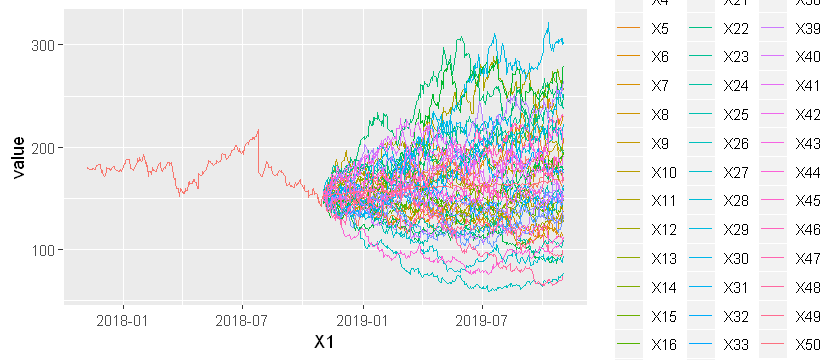

In [4]:
new_df = melt(df_mc, id='X1')

p = ggplot() + geom_line(data=new_df, aes(x=X1, y=value, colour=variable))
p

We plot then the average value of all simulations alongside the real price path. You can see that it misrepresented the amount of volatility of the asset price simulated. When we compute the average we get rid of the random character in our stochastic process. 

It is not recommended to construct a portfolio strategy based on a simple Monte-Carlo estimation of future prices with the GBM. However, Monte-Carlo have more utility in order regards. For pricing options for instance.

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.
Warning message:
"Removed 248 rows containing missing values (geom_path)."

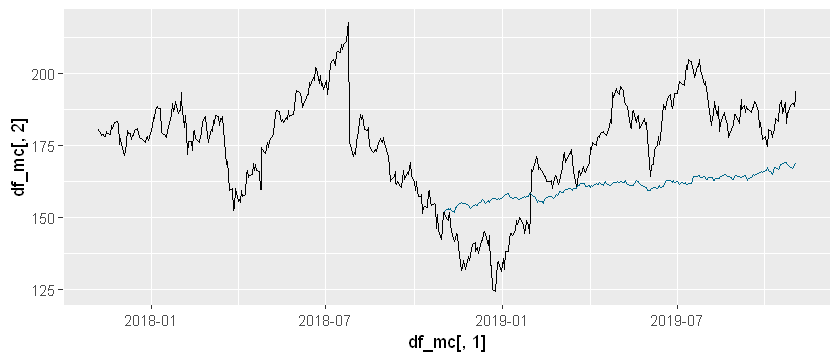

In [6]:
p1 <- ggplot() + geom_line(data=df_mc, aes(x=df_mc[,1], y=df_mc[,2])) +
  geom_line(data=df_mc, aes(x=df_mc[,1], df_mc[,nb_mc]), color='deepskyblue4') 
p1

### 2. Pricing options with Monte-Carlo and Black-Scholes formula

In order to create a personnal function in R we use **function()**. 

Usually, we input parameters of the function between parentheses and develop the computation of the function between brackets. A metaphorical example: 

my_function <- function(my_parameters){

do_stuff_with = my_paramters 

return (do_stuff_with)
    
} 

Here, we tackle first how to make a pricer for European option (call and put) by using the BlackScholes formula. Just as a reminder: 

$$ C_t = S_t N(d1) - exp^{-r_f (T-t)} K N(d2) $$

$$ P_t = exp^{-r_f (T-t)} K N(-d2) - S_t N(-d1) $$  

$$ d1 = \frac{ln(S_t/K)+(r_f+\frac{\sigma^2}{2})(T-t)}{\sigma \sqrt{T-t}} $$

$$ d2 = d1 - \sigma \sqrt{T-t} $$


We rewrite the mathematical formula in R code and add an *if* loop in our function to accept both calls and puts pricing. There it is you have wrote your first BlackScholes pricer ! 

In [7]:
# use of monte-carlo method for pricing options 
#Black Scholes 
my_blackscholes <- function(S,K,rf,t, sigma, option_type){
    
  d1 = (log(S/K)+(rf+(sigma**2)/2)*t)/(sigma*sqrt(t))
  d2 = d1 - sigma*sqrt(t)
    
  if (option_type=='call'){
    BS = S*pnorm(d1)-K*pnorm(d2)*exp(-rf*t)
  } else {
    BS = K*pnorm(-d2)*exp(-rf*t) - S*pnorm(-d1)
  }
    
  return(BS)
} 


my_blackscholes(100, 100, 0.04, 2, 0.01, 'call')

[1] 7.688365

The Monte-Carlo pricer is going to be a bit more complex than the BlackScholes. 

We can skip the *for* loop because the function **rnorm()** allows us to sample as much as we want from the normal distribution. Also, we now don't care about the path of the simulated price (as opposed as earlier when we needed to see the price path), this is why we call European option path-independent. 

Since the European option is not path-dependant we don't need to have an iterative construction of the price between now and the maturity. We solve the differential equation in order to get an equation linking today's price to the price at maturity. 

$ dS_t = S_t(\mu dt + \sigma dB_t)$ 

We assume that $X_t = ln(S_t)$ 

So, using Ito's lemma: 

$dX_t = \frac{\partial X_t}{\partial t}dt + \frac{\partial X_t}{\partial S_t}dS_t + \frac{1}{2}\frac{\partial^2 X_t}{\partial S_t^2}(dS_t)^2 $ 

We will see in class how to develop this expression. 

So the closed-form formula for simulating price at any time $t$ is: 

$$ S_t = S_0  e^{(r_f -\frac{\sigma^2}{2})t + \sigma \sqrt{t}  \epsilon}   $$

When we write **rnorm(10000, 0,1)** we sample 10000 nubmer from a N(0,1) law. So we just need to use the function **mean()** to average the 10000 values obtained and we have our simulated price at time $t$ ! 

For Monte-Carlo we precise that: 

$$ C_t = max(S_t-K, 0) $$ 

$$ P_t = max(K-S_t, 0) $$ 

By adding an *if* loop we make our Monte-Carlo pricer for both call and put options. 

In [8]:
# monte carlo
my_montecarlo_pricer <- function(nb_simu, S0, K, t, rf, sigma, option_type){
  drift = (rf-(sigma**2)/2)*t
  shock = sigma*sqrt(t)
  St = S0*exp(drift + shock*rnorm(nb_simu,0,1))
  
  if (option_type=='call'){
    MC = mean(pmax((St-K),0)*exp(-rf*t))
  } else {
    MC = mean(pmax((K-St),0)*exp(-rf*t))
  }
  return(MC)
} 
my_montecarlo_pricer(100000, 100,100,2,0.04,0.01,'call')


[1] 7.690677

It is also interesting to know how fast Monte-Carlo method converges to the "real" value of an option (here the real value is the one given by BS). 

In order to check it we follow the following procedure: 

We are going to compute both MC and BS for a growing number of **my_simu**. The BS will not change since it's not dependent on simulations. But the value of the MC pricer will. 

First, we create a list of growing numbers, starting from 100 and with a step of 200, for 1000 points. 

In a dataframe created for this (**data_option**) we store the values of MC and BS for each interation of i in my_simu. 

Finally, we plot both BS and MC for all numbers of simulations. 

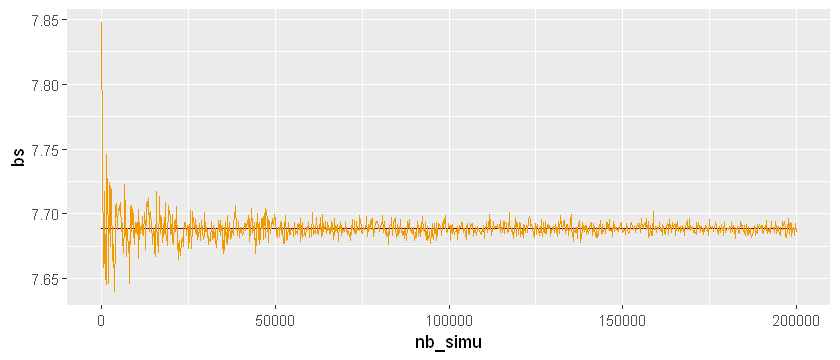

In [9]:
#compare monte-carlo and black scholes
simu_graph = 1000
data_option = data.frame(matrix(nrow=simu_graph, ncol=3))

my_simu = list()
my_simu[1] = 100
for (i in 2:simu_graph){
  my_simu[i] = as.numeric(my_simu[(i-1)]) + 200
}

r=1
for (i in my_simu){
  data_option[r,1] = i
  data_option[r,2] = my_blackscholes(100,100,0.04,2,0.01,'call')
  data_option[r,3] = my_montecarlo_pricer(i, 100,100,2,0.04,0.01,'call')
  r = r+1
}
colnames(data_option)=c('nb_simu', 'bs', 'mc')

p <- ggplot(data=data_option, aes(x=nb_simu)) +
  geom_line(aes(y=bs), color='darkred') +
  geom_line(aes(y=mc), color='orange2')
p 
  

We can see that the convergence process is relatively quick. It needs 50000 simulations to have an error situated between -0.025 and +0.025

We can also create a function that gives us the Greeks for a European option. We can get the formula and just translate them into R code: 

For Call options: 
$$ \Delta_{call} = N(d1) $$

$$  V_{call} =  S \phi(d1) \sqrt{T-t}  $$

$$ \rho_{call} = K (T-t) e^{-r_f(T-t)} \phi(d2)$$

$$ \Theta_{call} = -S_t \sigma \frac{N(d1)}{2 \sqrt{T-t}} - r_f K e^{-r_f(T-t)}\phi(d2)$$

$$ \Gamma_{call} = \frac{N(d1)}{S_t \sigma \sqrt{T-t}}$$


And for Put Options: 
$$ \Delta_{put} = -N(-d1) $$

$$  V_{put} =  S \phi(d1) \sqrt{T-t}  $$

$$ \rho_{put} = -K (T-t) e^{-r_f(T-t)} \phi(-d2)$$

$$ \Theta_{put} = -S_t \sigma \frac{N(-d1)}{2 \sqrt{T-t}} + r_f K e^{-r_f(T-t)}\phi(-d2)$$

$$ \Gamma_{put} = \frac{N(d1)}{S_t \sigma \sqrt{T-t}}$$


In [17]:
# how to get greeks from bs and montecarlo
my_bs_greeks <- function(S, K, rf, t, sigma, option_type){
  d1 = (log(S/K)+(rf+(sigma**2)/2)*t)/(sigma*sqrt(t))
  d2 = d1 - (sigma*sqrt(t))
  
  if (option_type=='call'){
    delta = pnorm(d1)
    vega = S*dnorm(d1)*sqrt(t)
    rho = K*t*exp(-rf*t)*pnorm(d2)
    theta = -S*sigma*dnorm(d1)/(2*sqrt(t))-rf*K*exp(-rf*t)*pnorm(d2)
    gamma = dnorm(d1)/(sigma*sqrt(t)*S)
  } else if(option_type=='put') {
    delta = - pnorm(-d1)
    vega = S*dnorm(d1)*sqrt(t)
    rho = -K*t*exp(-rf*t)*pnorm(-d2)
    theta = -S*sigma/(2*sqrt(t))*dnorm(-d1)+rf*K*exp(-rf*t)*pnorm(-d2)
    gamma = dnorm(d1)/(sigma*sqrt(t)*S)
  }
  return(list(delta=delta,vega=vega,rho=rho,theta=theta,gamma=gamma))
}


#Black_Scholes_Greeks(t=0, S=100, r=0.04, sigma=0.1, K=100, T=2)
my_bs_greeks(S=100,K=100,rf=0.04,t=2,sigma=0.1,'call')


$delta
[1] 0.7377409

$vega
[1] 46.0766

$rho
[1] 127.333

$theta
[1] -3.698575

$gamma
[1] 0.0230383

### 3. Pricing path dependent options : Asian Options 

Asian option are path-dependent options since their value depend on the average value of the underlying asset over the all period considered. Formally, we define them as: 

$$ C_t = max( \frac{1}{n}\sum \limits_{i=1}^{n} S_i-K, 0) $$ 

$$ P_t = max( K - \frac{1}{n}\sum \limits_{i=1}^{n} S_i, 0) $$ 

There isn't a closed form solution for Asian options so our best option is to use Monte-Carlo method in order to compute numerous price paths and average them together afterwards. 

We create a dataframe inside the function (**Asian_Brownian**) that will store the value of all price paths (columns) and for all time steps (rows). Each columns is a different price path and each price paths expand over all time steps (rows). 

So the first *for* loop makes us go trhough all the columns. While the second loop developp all time steps for each individual column. 

At the end, we need to average each price paths. We use **colMeans()** from **arrayhelpers** for this purpose. And we average for all simulations, the value of this option for each particular price paths. 

By using the *if* loop, we allow ourselves to compute both Put and Call Asian options.

In [8]:
Asian_opt_pricer <- function(S, K, rf, t, sigma, option_type, nb_simu, time_step){
  dt = t/time_step
  drift = rf*dt
  shock = sigma*sqrt(dt)
  
  Asian_Brownian = data.frame(matrix(nrow=time_step, ncol=nb_simu))
  Asian_Brownian[1,] = rep(S, nb_simu)
  
  for(j in 1:nb_simu ){
    for(i in 2:time_step){
      Asian_Brownian[i,j] = Asian_Brownian[i-1,j]*(1+drift+shock*rnorm(1))

    }
  }
  
  pre_asian = colMeans(Asian_Brownian)
  if(option_type=='call'){
    asian = mean(pmax((pre_asian-K),0))
  } else {
    asian = mean(pmax((K-pre_asian),0))
  }
  return(asian)
}


Asian_opt_pricer(S=100, K=100, rf=0.04, t=1, sigma=0.1, option_type='put', nb_simu=1000, time_step=500)

#from derivmkts
#arithasianmc(s=100, k=100, v=0.1, r=0.04, tt=1, d=0, m=1000, numsim=2000)


[1] 1.411104